In [33]:
%matplotlib inline

from datetime import datetime
import backtrader as bt
import backtrader.feeds as btfeeds
import yfinance as yf
import tulipy as ta
import matplotlib.pyplot as plt
import tiingo
import pandas as pd 
import pyfolio as pf
import math
import numpy as np

# QuantStats

In [34]:
class QuantConnectCSVData(btfeeds.GenericCSVData):

    params = (
        ('nullvalue', float('NaN')),
        ('dtformat', '%Y:%m:%d'),
        ('datetime', 0),
        ('time', 1),
        ('open', 2),
        ('high', 3),
        ('low', 4),
        ('close', 5),
        ('volume', 6),
        ('openinterest', -1),
        ('timeframe', bt.TimeFrame.Minutes), 
        ('compression', 240),
    )

In [35]:
class TiingoCSVData(btfeeds.GenericCSVData):
    lines = ('inSPY',)
    
    params = (
        ('nullvalue', float('NaN')),
        ('dtformat', '%Y-%m-%d'),
        ('datetime', 0),
        ('open', 9),
        ('high', 7),
        ('low', 8),
        ('close', 6),
        ('volume', 10),
        ('inSPY', 13),
        ('openinterest', -1),
    )

In [36]:
class RSIt(bt.Strategy):

    params = (('oneplot', True),
                ('tp_multiplier', 5),
                ('sl_multiplier', 3),
                ('ATR_Period', 14),
                ('bk_period', 100),
                )

    def __init__(self):
        self.inds = dict()
        for i, d in enumerate(self.datas):
            self.inds[i] = dict()
            self.inds[i]['ATR']= bt.indicators.AverageTrueRange(d, period=self.p.ATR_Period)
            self.inds[i]['bkhigh'] = bt.indicators.Highest(d,period=self.p.bk_period)
            self.inds[i]['bklow'] = bt.indicators.Lowest(d, period=self.p.bk_period)

            if i > 0:
                if self.p.oneplot == True:
                    d.plotinfo.plotmaster = self.datas[0]

    def next(self):
        for i, d in enumerate(self.datas):
            dt, dn = self.datetime.date(), d._name
            pos = self.getposition(d).size
            cash = self.broker.getcash()
            dt = self.data.datetime.date()
            if not pos:  # no market / no orders
                if (d.close[0] != 0) and (d.inSPY[0] == 1):
                    if (d.close[0] > self.inds[i]['bkhigh'][-1]):
                        # self.buy(data=d, size=100)                    
                        price = d.close[0]
                        price_limit = price + (self.p.tp_multiplier*self.inds[i]['ATR'][0])
                        price_stop = price - (self.p.sl_multiplier*self.inds[i]['ATR'][0])
                        qty = round((cash*0.01)/(price - price_stop))

                        if qty != 0:    
                            self.buy_bracket(
                                data=d,
                                size=qty,
                                exectype=bt.Order.Market,
                                limitprice=price_limit,
                                price=price,
                                stopprice=price_stop,
                                )

                    elif (d.close[0] < self.inds[i]['bklow'][-1]):
                        # self.sell(data=d, size=100)

                        price = d.close[0]
                        price_limit = price - (self.p.tp_multiplier*self.inds[i]['ATR'][0])
                        price_stop = price + (self.p.sl_multiplier*self.inds[i]['ATR'][0])
                        qty = round((cash*0.01)/(price_stop - price))

                        if qty != 0: 
                            self.sell_bracket(
                                    data=d,
                                    price=price,
                                    size=qty,
                                    exectype=bt.Order.Market,
                                    stopprice=price_stop,
                                    limitprice=price_limit,
                                )
                else:
                    pass
            
            elif pos:
                pass
    

#         def stop(self):
#             print('LB Params: {} End value: {}'.format(self.p.bk_period, self.broker.getvalue()))
                
    def notify_trade(self, trade):
        dt = self.data.datetime.date()
        if trade.isclosed:
            print('{} {} Closed: PnL Gross {}, Net {}, Cash left {:.2f}'.format(
                                                dt,
                                                trade.data._name,
                                                round(trade.pnl,2),
                                                round(trade.pnlcomm,2),
                                                self.broker.getcash()))

In [37]:
class printTest(bt.Strategy):
    
    params = (('text', 1),
            )
    
    def __init__(self):
        self.inds = dict()
        bt.indicators.SMA(self.data.inSPY, period=1, subplot=False)
        for i,d in enumerate(self.datas):
            print(i,d)
            print(self.p.text)

In [43]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(RSIt, bk_period=30)
cerebro.addanalyzer(bt.analyzers.PyFolio)

#add datafeeds
for i in range(len(datalist)):
    data = TiingoCSVData(dataname=f'./data/{datalist[i]}.csv')
    cerebro.adddata(data, name=datalist[i])

# Set our desired cash start
cerebro.broker.setcash(100000.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strats = cerebro.run()
firstStrat = strats[0]

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
2000-02-24 A Closed: PnL Gross 1888.7, Net 1888.7, Cash left 99784.59
2000-03-06 A Closed: PnL Gross 1844.96, Net 1844.96, Cash left 101629.54
2000-03-14 A Closed: PnL Gross -916.7, Net -916.7, Cash left 100712.84
2000-03-22 AABA Closed: PnL Gross -851.36, Net -851.36, Cash left 96197.28
2000-04-04 AABA Closed: PnL Gross -870.17, Net -870.17, Cash left 95327.11
2000-05-19 AAPL Closed: PnL Gross -938.72, Net -938.72, Cash left 105551.27
2000-07-10 AAPL Closed: PnL Gross -1067.77, Net -1067.77, Cash left 104483.50
2000-08-03 AAPL Closed: PnL Gross -1121.37, Net -1121.37, Cash left 103362.13
2000-08-25 AAPL Closed: PnL Gross -889.57, Net -889.57, Cash left 102472.57
2000-09-22 AAPL Closed: PnL Gross -1142.8, Net -1142.8, Cash left 101329.77
2000-10-11 AABA Closed: PnL Gross 1640.76, Net 1640.76, Cash left 101576.31
2000-12-20 AABA Closed: PnL Gross 1752.16, Net 1752.16, Cash left 103328.47
2001-01-24 AABA Closed: PnL Gross -1115.9, Net -1115.9, Cash lef

In [38]:
import os
path = R'.\data'
files = [os.path.splitext(filename)[0] for filename in os.listdir(path)]

In [40]:
datalist = files[:10]

In [12]:
%matplotlib widget

cerebro.plot(iplot=False,style='candle', bardown='yellow', volume=False)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

[[<Figure size 640x480 with 3 Axes>]]

In [44]:
pyfoliozer = firstStrat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

In [45]:
import quantstats as qs

returns_qs = returns.tz_convert(None)
transactions_qs = transactions.tz_convert(None)
positions_qs = positions.tz_convert(None)

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2000-01-03  2000-01-03
End Period                 2020-12-04  2020-12-04
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          106.08%     271.56%
CAGR%                      3.51%       6.47%
Sharpe                     0.45        0.41
Sortino                    0.66        0.58
Max Drawdown               -14.19%     -55.19%
Longest DD Days            1071        2404
Volatility (ann.)          8.41%       19.92%
R^2                        0.04        0.04
Calmar                     0.25        0.12
Skew                       0.33        0.01
Kurtosis                   8.61        12.2

Expected Daily %           0.01%       0.02%
Expected Monthly %         0.29%       0.52%
Expected Yearly %          3.5%        6.45%
Kelly Criterion            2.23%       2.41%
Risk of Ruin               0.0%    

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2015-08-26,2017-01-30,2018-01-26,884,-14.192881,-13.519112
2,2007-08-17,2008-05-22,2008-11-20,461,-13.034947,-12.728913
3,2018-01-29,2019-07-17,2020-03-12,773,-12.188841,-11.943214
4,2020-03-24,2020-04-17,2020-12-04,255,-9.826486,-9.550803
5,2002-10-10,2004-04-06,2005-09-15,1071,-9.550997,-8.506371


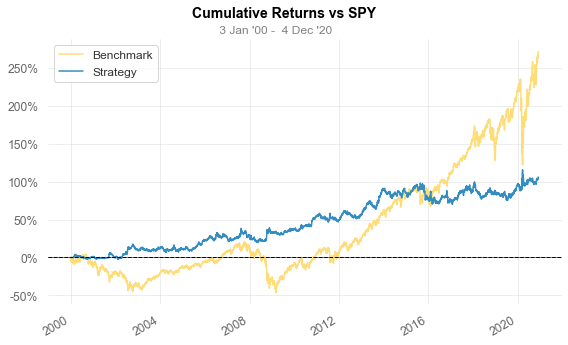

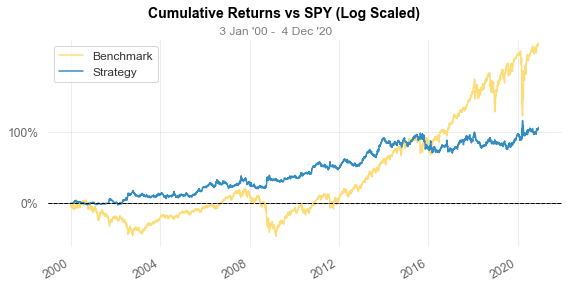

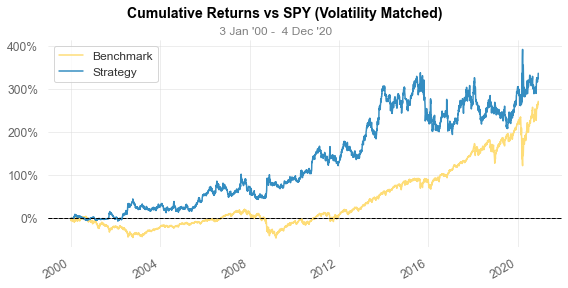

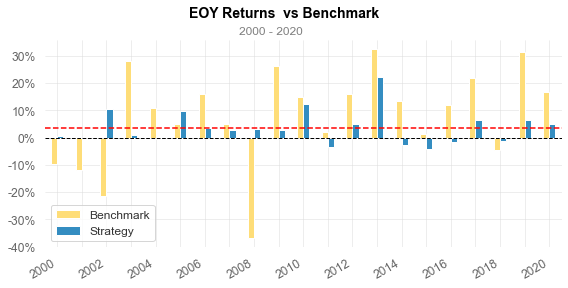

X:\Environments\Backtesting\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


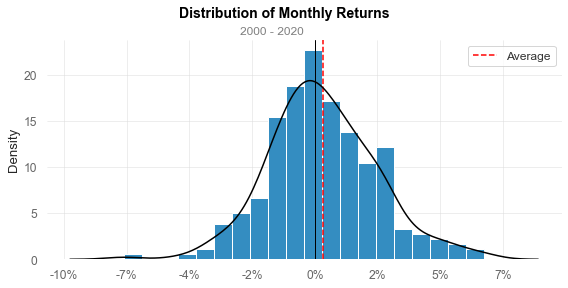

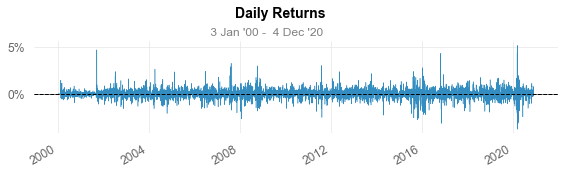

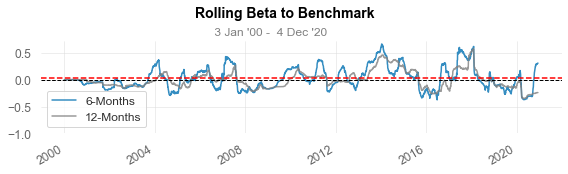

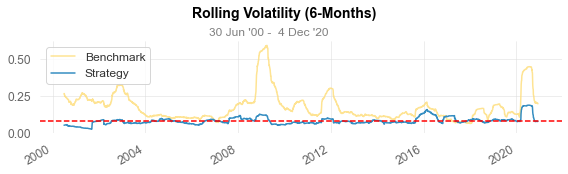

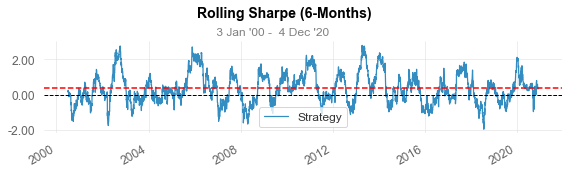

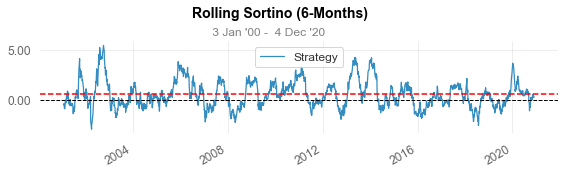

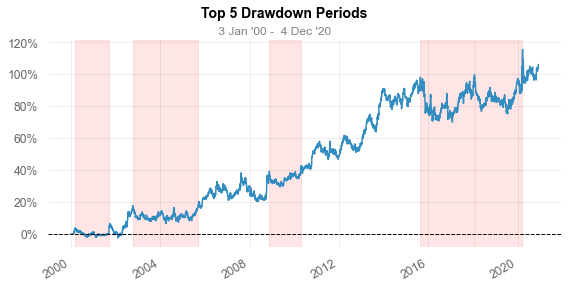

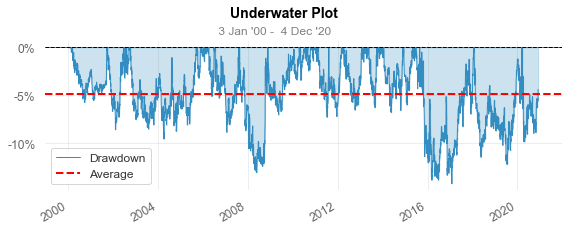

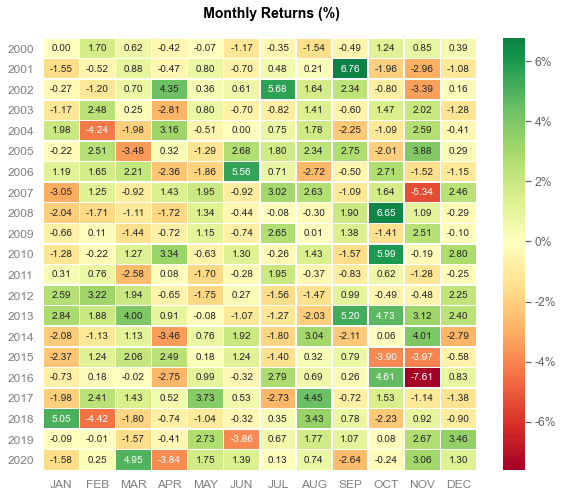

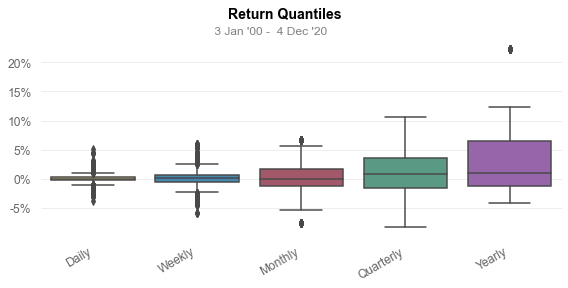

In [47]:
qs.reports.full(returns_qs,"SPY")

Start date,2000-01-03
End date,2020-12-04
Total months,250
,Backtest
Annual return,3.521%
Cumulative returns,106.085%
Annual volatility,8.408%
Sharpe ratio,0.45
Calmar ratio,0.25
Stability,0.95
Max drawdown,-14.193%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,14.19,2015-08-25,2017-01-30,2018-01-26,634
1,13.03,2007-08-16,2008-05-22,2008-11-20,331
2,12.19,2018-01-26,2019-07-17,2020-03-12,555
3,9.83,2020-03-23,2020-04-17,NaT,NaN
4,9.55,2002-10-09,2004-04-06,2005-09-15,767


X:\Environments\Backtesting\lib\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
X:\Environments\Backtesting\lib\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
X:\Environments\Backtesting\lib\site-packages\pandas\plotting\_matplotlib\tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
X:\Environments\Backtesting\lib\site-packages\pandas\plo

Stress Events,mean,min,max
Lehman,0.05%,-1.49%,1.74%
EZB IR Event,-0.08%,-0.69%,0.90%
Flash Crash,-0.49%,-1.36%,0.68%
Apr14,-0.16%,-2.27%,1.19%
GFC Crash,0.01%,-2.67%,3.24%


X:\Environments\Backtesting\lib\site-packages\pandas\core\arrays\datetimes.py:1099: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
X:\Environments\Backtesting\lib\site-packages\pandas\core\arrays\datetimes.py:1099: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
X:\Environments\Backtesting\lib\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
X:\Environments\Backtesting\lib\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum]

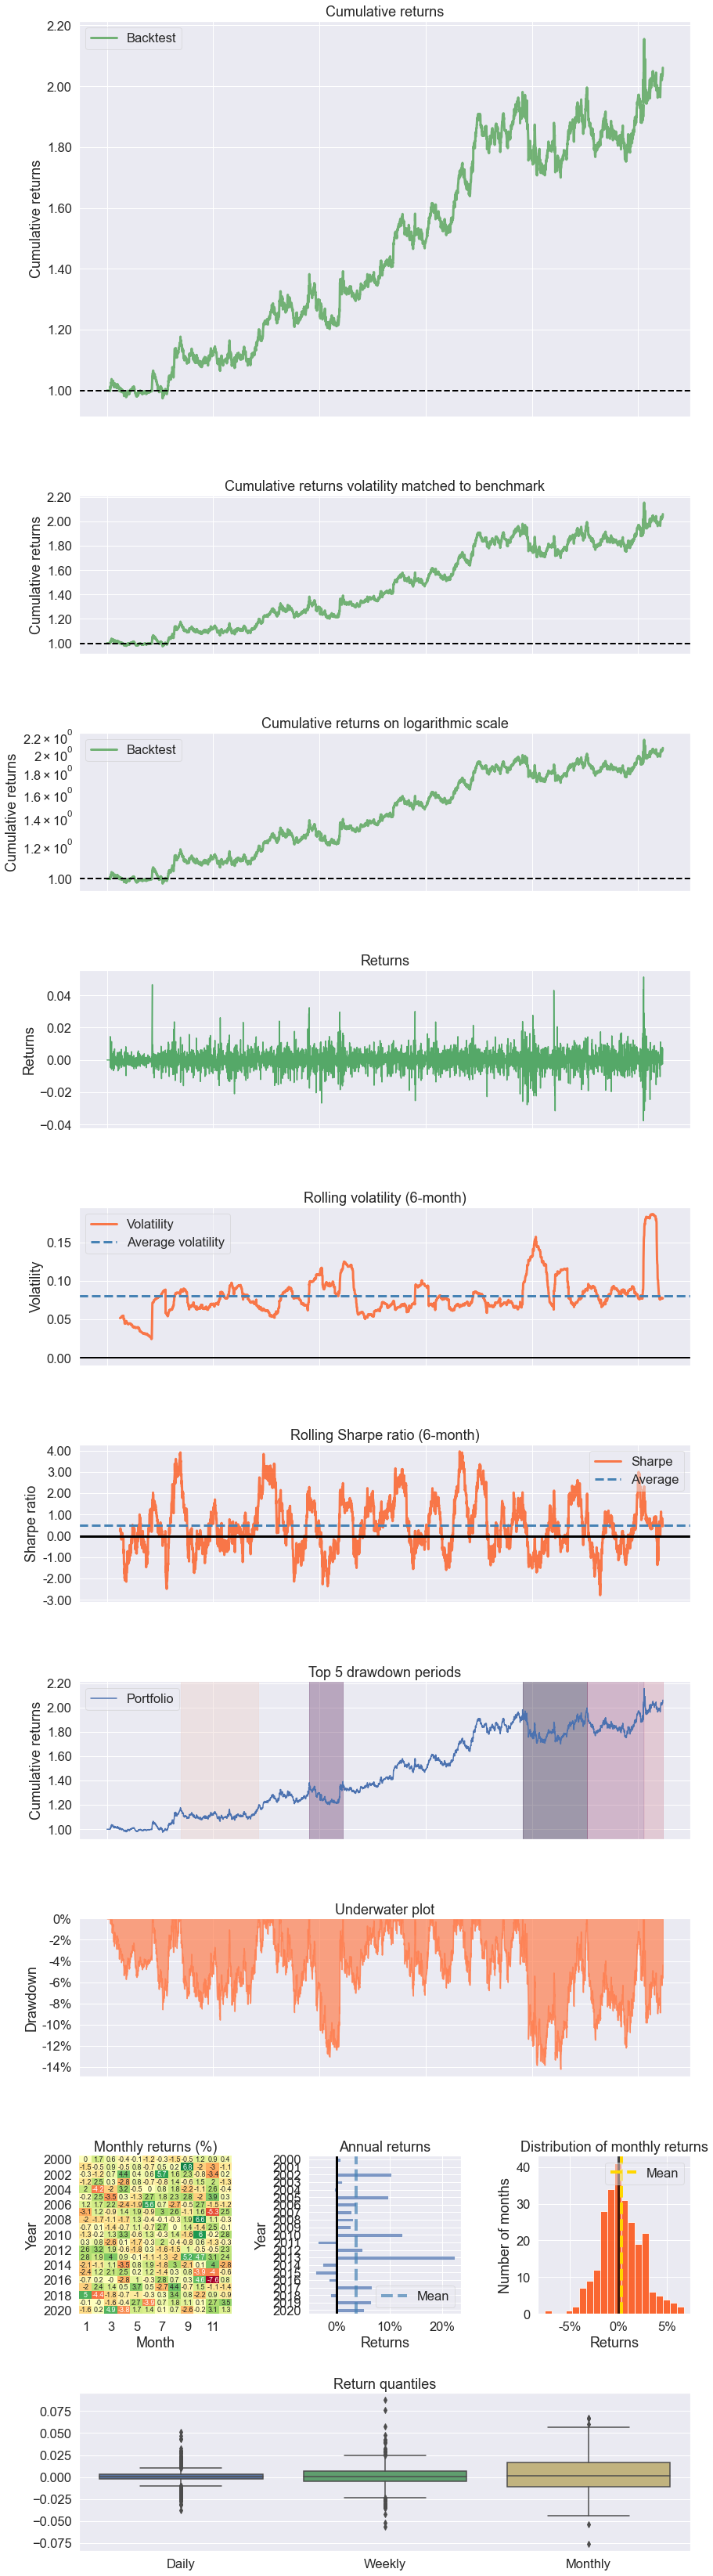

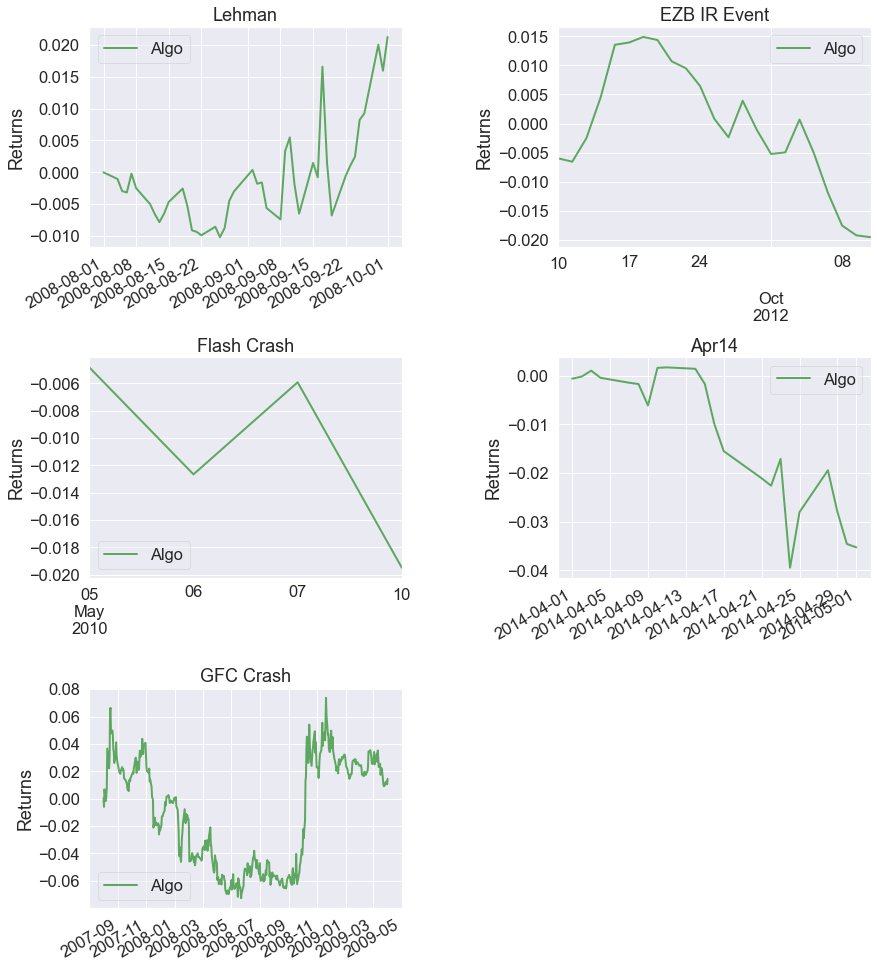

In [48]:
pf.create_full_tear_sheet(returns=returns,transactions=transactions)